# Volumetric searchlight hyperalignment

<br><br>
<font size="4">
Notebook to try and make searchlight hyperalignment work. We start with the volumetric searchlight case, following the example provided here:
http://www.pymvpa.org/examples/hyperalignment.html

We already have a toy dataset (4 subjects) arranged in pymvpa dataset format, here we just try to derive and validate the hyperalignment mappings.
</font>
<br>

## 1. Basics: imports, loading data
<br>

In [1]:
from mvpa2.suite import *

/afs/dbic.dartmouth.edu/usr/wheatley/welkechr/.conda/envs/hyperalignment_practice/lib/python2.7/site-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif


<font size="4">
(Sidenote: These warnings seem worrisome, but pymvpa is undergoing migration to python3, hopefully that will solve these looming crashes)
</font>

In [2]:
import sys
import numpy as np
import time
from matplotlib import pyplot
from nilearn import datasets, surface, plotting
#from nilearn import surface
#from nilearn import plotting


/afs/dbic.dartmouth.edu/usr/wheatley/welkechr/.conda/envs/hyperalignment_practice/lib/python2.7/site-packages/nilearn/__init__.py:73: DeprecationWarning: Python2 support is deprecated and will be removed in the next release. Consider switching to Python 3.6 or 3.7.
  _python_deprecation_warnings()


<br>
<font size="4">
<b>Loading the dataset:</b> 4 subjects' bold fmri timeseries from the audio listening and reading tasks. Data was preprocessed and concatenated for each subject using the earlier scripts (nuisRegr_runs34.py and a new version of concat_hyperalign.py).
</font>
<br><br>

In [3]:

folderPath = '/afs/dbic.dartmouth.edu/usr/wheatley/welkechr/Hyperalignment_Practice/Data_Subset/'
datasetName = 'hyperDataset.hdf5'
ds = h5load(folderPath+datasetName)

/afs/dbic.dartmouth.edu/usr/wheatley/welkechr/.conda/envs/hyperalignment_practice/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


<br>
<font size="4">
Similar to nilearn, Pymvpa datasets are "flattened", that is, they are stored as 2D numpy arrays with dimensions <i>samples</i> (==TRs) and <i>features</i> (==voxels). We verify that all datasets have the same dimensions:
</font>
<br><br>

In [4]:
for data in range(len(ds)):
    print ds[data].shape
    

(946, 68783)
(946, 68783)
(946, 68783)
(946, 68783)
(946, 68783)
(946, 68783)
(946, 68783)
(946, 68783)


## 2. Initial ISC (simple correlation) results 
<br>
<font size="4">
Before hyperalignment, we correlate each subject's data to the group mean formed by averaging the data from the rest of the subjects. If hyperalignment works as expected, by definition, these correlations should be stronger after hyperalignment.   
</font>
<br><br>

In [ ]:
# no. of datasets we use here
dataNo = len(ds)
# dataset shape as list
dataShape = list(ds[0].shape)  # TRs X voxels (== samples X features in pymvpa lingo)

# result matrix for storing all correlation coeffs: subjects X voxels (==features)
corrRes = np.empty([dataNo, dataShape[1]])
print 'Results matrix is empty array of size ' + str(corrRes.shape)

# we extract the group data into one np array from the datasets so we can calculate with it more easily
# (this step feels unneccessary, but I always run into problems when 
# trying to calculate with the pymvpa dataset arrays directly - maybe later I'll figure it out)
groupData = np.empty([dataNo, dataShape[0], dataShape[1]])
for subIdx in range(dataNo):
    groupData[subIdx, :, :] = ds[subIdx].__array__()
    
# go through subjects, correlate with the rest of the group
for subIdx in range(dataNo):
    
    # indices for everyone except the main subject in the loop
    groupIndices = list(range(dataNo))
    del(groupIndices[subIdx])
    # mean data for everyone except our subject of interest
    groupMean = np.mean(groupData[groupIndices, :, :], 0)
    
    startTime = time.time()
    for voxel in range(dataShape[1]):
        # it is inefficient this way, should use stg like np.dot() with vector magnitude normalization
        # e.g. np.dot(a,b)/(np.sqrt(a.dot(a))*np.sqrt(b.dot(b))) ???
        corrRes[subIdx, voxel] = np.corrcoef(ds[subIdx].__array__()[:, voxel], groupMean[:, voxel], rowvar=False)[0, 1]
    finishTime = time.time()-startTime
    print 'Calculations for sub ' + str(subIdx) + ' took ' + str(finishTime) + ' secs'
    
# mean correlation map
meanCorr = np.mean(corrRes, 0)

# look at the overall spread of values
_ = pyplot.hist(meanCorr, 100)

# get a feel of the data
print '\n'
print str(sum(meanCorr>0.1)) + ' voxels show a correlation coeff > 0.1'
print str(sum(meanCorr>0.2)) + ' voxels show a correlation coeff > 0.2'
print str(sum(meanCorr>0.3)) + ' voxels show a correlation coeff > 0.3'

<br>
<font size="4">
<b>Looks nice, showing the expected widespread correlations. </b>

Now that we have the initial group-level correlation map, let's transform it back into a 3D nifti image and take a look. We use the built-in methods of pymvpa datasets, and substitute our correlation value array as imaging data array. For details look in this tutorial: http://www.pymvpa.org/tutorial_mappers.html     
</font>
<br><br>

In [6]:
# each dataset keeps the transformations that have been applied to the original data as so-called mappers
print 'Mappers of our datasets: ' + str(ds[0].a.mapper)

# we don't need to get into the details of the mappers here, 
# we can simply reverse them for the correlation values, using the wrapper "map2nifti" in pymvpa
corrImg = map2nifti(ds[0], meanCorr)
# we see that the result is as expected, a nifti image as implemented in nibabel
print '\nAfter map2nifti, data is in an object of : ' + str(type(corrImg))

# however, there is no affine (a bug? in pymvpa), despite the information present in the header
print '\ncorrImg affine is : ' + str(corrImg.affine)
# so we need a stupid workaround before using the img: saving and loading it again
corrImg.to_filename('initialCorrResults.nii')
corrImg = nb.load('initialCorrResults.nii')
print '\nAfter saving and loading, affine is: ' + str(corrImg.affine)


Mappers of our datasets: <Chain: <Flatten>-<StaticFeatureSelection>>

After map2nifti, data is in an object of : <class 'nibabel.nifti1.Nifti1Image'>

corrImg affine is : None

After saving and loading, affine is: [[   3.    0.    0.  -96.]
 [   0.    3.    0. -132.]
 [   0.    0.    3.  -78.]
 [   0.    0.    0.    1.]]


<br>
<font size="4">
Now that we have a proper nifti image, there are countless ways to plot it. Here we project to the surface using nilearn, just to stay in the python universe:
</font>
<br><br>

<div class="alert alert-block alert-warning">
    <font size ="4">
    <b>This part can take a few minutes!</b>
    </font>
</div>

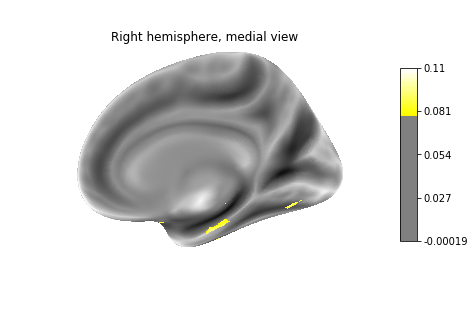

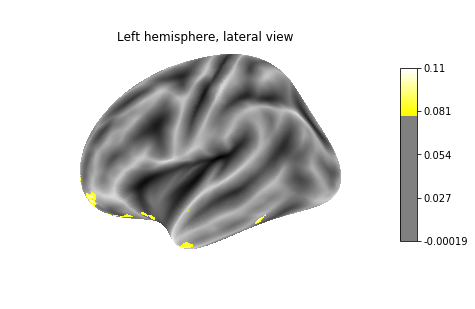

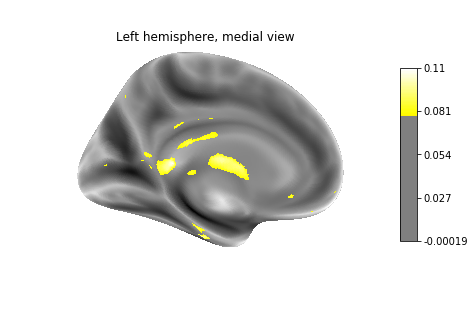

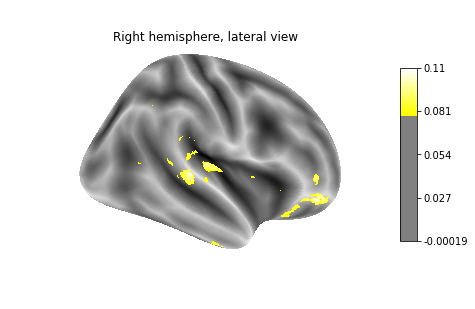

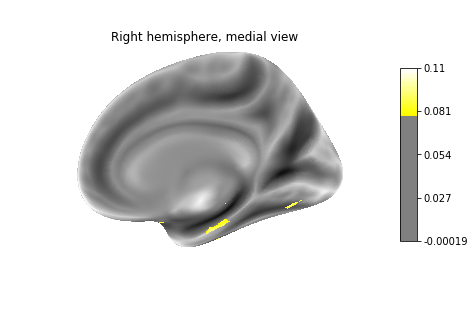

In [8]:
# visualization with nilearn
# thresholding the map at +0.10 as the minimum correlation we want to see

# load the fsaverage surface template
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage')
# create a texture from the volumetric data
texture = surface.vol_to_surf(corrImg,
                              fsaverage.pial_left,
                              interpolation='linear'
                              )
# 4 plots: left lateral and medial, right lateral and medial
plotting.plot_surf_stat_map(fsaverage.infl_left,
                            texture,
                            hemi='left',
                            threshold=0.08,
                            bg_map=fsaverage.sulc_left,
                            view='lateral',
                            symmetric_cbar=False,
                            title='Left hemisphere, lateral view'
                            )
plotting.plot_surf_stat_map(fsaverage.infl_left,
                            texture,
                            hemi='left',
                            threshold=0.08,
                            bg_map=fsaverage.sulc_left,
                            view='medial',
                            symmetric_cbar=False,
                            title='Left hemisphere, medial view'
                            )
plotting.plot_surf_stat_map(fsaverage.infl_right,
                            texture,
                            hemi='right',
                            threshold=0.08,
                            bg_map=fsaverage.sulc_right,
                            view='lateral',
                            symmetric_cbar=False,
                            title='Right hemisphere, lateral view'
                            )
plotting.plot_surf_stat_map(fsaverage.infl_right,
                            texture,
                            hemi='right',
                            threshold=0.08,
                            bg_map=fsaverage.sulc_right,
                            view='medial',
                            symmetric_cbar=False,
                            title='Right hemisphere, medial view'
                            )


<br>
<font size="4">
This is mostly nice: large correlations in temporal, inferior parietal, sensorimotor and inferior frontal regions with left laterality, just as one would expect in a language comprehension / production task. Also nice pattern on the medial surfaces (posterior cingulate, SMA, precuneus, etc.). However, the bright blob on the left medial surface is really close to the ventricles and perhaps some of the bright right medial blob as well... 
    
 <br>
 
Outside python (fsleye, but any other viewing program could work), I checked the average correlation results as overlayed on the corresponding anatomical, and it really seems to stem, at least partially, from the ventricles. You can check it yourself: as background anatomical use the ICBM 2009c Nonlinear Asymmetric version from here: http://www.bic.mni.mcgill.ca/ServicesAtlases/ICBM152NLin2009. You can download the nifti files, and look for the one called "mni_icbm152_t1_tal_nlin_asym_09c.nii" - that is the T1 weighted nonlinear asymmetric anatomical that we used for our data as the registration template.


The strong correlations in the ventricles might come from movement that our confound variables did not catch. I am thinking that in the reading task specifically, people more-or-less move their head in synch, resulting in strong artefacts. As right now we only want to check the effects of hyperalignment we do not have to care too much, but later we need to revisit this issue and update our nuisance regression methods. E.g. we could try more regressors (e.g. 12 movement components instead of the 6 we used, more aCompCor components, etc). 
</font>
<br><br>

## 3. Searchlight hyperalignment - sanity check
<br>
<font size="4">
Now we can turn to hyperalignment itself. To make sure the procedure works as it should, we perform hyperalignment on all our data and then calculate the correlations with the group averages again. For the hyperalignment itself, we follow 
<a href="http://www.pymvpa.org/examples/hyperalignment.html#searchlight-hyperalignment">the corresponding tutorial at pyvmpa.org</a>

First, let's calculate the hyperaligment mappings into the common space for all subjects, using all the data we have.
</font>
<br><br>

<div class="alert alert-block alert-warning">
    <font size ="4">
    <b>This part can take a few minutes!</b>
    </font>
</div>

In [8]:
# we call SearchlightHyperalignment mostly with default values: 
# each sphere has a radius of 3 voxels, sphere centers are also 3 voxels apart, 
# all voxels in a given sphere are used for alignment
slhyper = SearchlightHyperalignment(radius=3, 
                                    sparse_radius=3, 
                                    nproc=3)

slhyperStart = time.time()
# call the hyperalignment object with the full dataset we have, 
# resulting mappers will be stored in slhypmaps
slhypermaps = slhyper(ds)
print '\nHyperalignment took ' + str(time.time()-slhyperStart) + ' secs'


 * Please note: warnings are printed only once, but underlying problem might occur many times *

Hyperalignment took 697.728200912 secs


<br>
<font size ="4">
The second warning is because we use data from two different runs, and those were cleaned and z-scored separately, before concatanetion. As the difference from 0 mean is minimal, we do not care now. Later, when run on larger datasets we will add an additional z-scoring step after concatenation.
    
Let's save out the mappings and then verify that they are Pymvpa mapper objects.    
</font>
<br><br>

In [9]:
# save into hdf5, it is quite large
h5save('hyperMappings.hd5', slhypermaps)
print type(slhypermaps[0])

<class 'mvpa2.mappers.staticprojection.StaticProjectionMapper'>


<br>
<font size ="4">
Apply the mappers. The output will be the dataset projected into the common space.    
</font>
<br><br>

In [10]:
dsHyper = []
# loop through subjects
for subIdx in range(dataNo):
    startT = time.time()
    # the mapper supports both forward and reverse mappings as methods
    dsHyper.append(slhypermaps[subIdx].forward(ds[subIdx]))
    print 'Projection for subject ' + \
        str(subIdx) + ' took ' + str(time.time()-startT) + ' secs'


Projection for subject 0 took 6.64784502983 secs
Projection for subject 1 took 6.34083390236 secs
Projection for subject 2 took 6.33775186539 secs
Projection for subject 3 took 6.39844799042 secs


<br>
<font size ="4">
So far so good. Now we re-run the correlations with the hyperaligned data and plot the results. Fingers crossed!
</font>
<br><br>

<div class="alert alert-block alert-warning">
    <font size ="4">
    <b>These parts below can take a few minutes!</b>
    </font>
</div>

Results matrix for hyperalligned data is empty array of size (4, 69747)
Calculations for sub 0 took 5.07184505463 secs
Calculations for sub 1 took 5.08567905426 secs
Calculations for sub 2 took 5.37346410751 secs
Calculations for sub 3 took 5.32949304581 secs


69741 voxels show a correlation coeff > 0.1
52514 voxels show a correlation coeff > 0.2
5523 voxels show a correlation coeff > 0.3


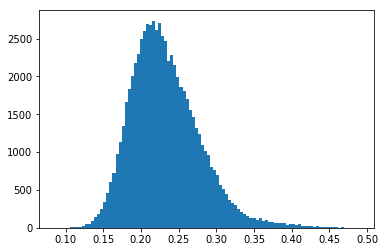

In [11]:

# result matrix for storing all correlation coeffs: subjects X voxels (==features)
corrResHyper = np.empty([dataNo, dataShape[1]])
print 'Results matrix for hyperalligned data is empty array of size ' + str(corrResHyper.shape)

# we extract the group data into one np array from the datasets so we can calculate with it more easily
# (this step feels unneccessary, but I always run into problems when 
# trying to calculate with the pymvpa dataset arrays directly - maybe later I'll figure it out)
groupData = np.empty([dataNo, dataShape[0], dataShape[1]])
for subIdx in range(dataNo):
    groupData[subIdx, :, :] = dsHyper[subIdx].__array__()
    
# go through subjects, correlate with the rest of the group
for subIdx in range(dataNo):
    
    # indices for everyone except the main subject in the loop
    groupIndices = list(range(dataNo))
    del(groupIndices[subIdx])
    # mean data for everyone except our subject of interest
    groupMean = np.mean(groupData[groupIndices, :, :], 0)
    
    startTime = time.time()
    for voxel in range(dataShape[1]):
        # it is inefficient this way, should use stg like np.dot() with vector magnitude normalization
        # e.g. np.dot(a,b)/(np.sqrt(a.dot(a))*np.sqrt(b.dot(b))) ???
        corrResHyper[subIdx, voxel] = np.corrcoef(dsHyper[subIdx].__array__()[:, voxel], groupMean[:, voxel], rowvar=False)[0, 1]
    finishTime = time.time()-startTime
    print 'Calculations for sub ' + str(subIdx) + ' took ' + str(finishTime) + ' secs'
    
# mean correlation map
meanCorrHyper = np.mean(corrResHyper, 0)

# look at the overall spread of values
_ = pyplot.hist(meanCorrHyper, 100)

# get a feel of the data
print '\n'
print str(sum(meanCorrHyper>0.1)) + ' voxels show a correlation coeff > 0.1'
print str(sum(meanCorrHyper>0.2)) + ' voxels show a correlation coeff > 0.2'
print str(sum(meanCorrHyper>0.3)) + ' voxels show a correlation coeff > 0.3'

In [12]:
# get image from the correlation coeff values 
corrImgHyper = map2nifti(dsHyper[0], meanCorrHyper)
# stupid workaround again
corrImgHyper.to_filename('hyperCorrResults.nii')
corrImgHyper = nb.load('hyperCorrResults.nii')


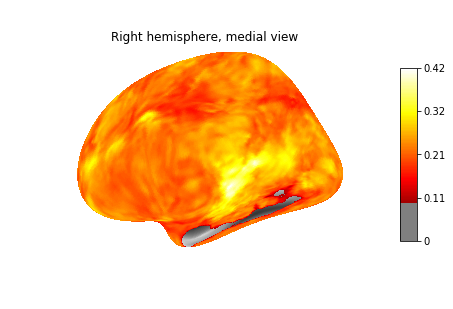

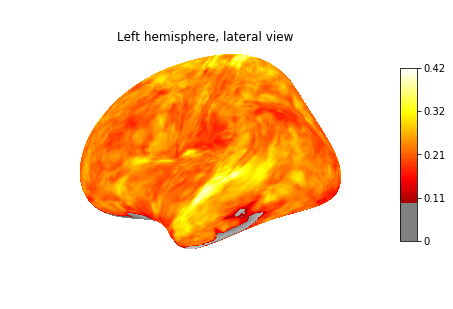

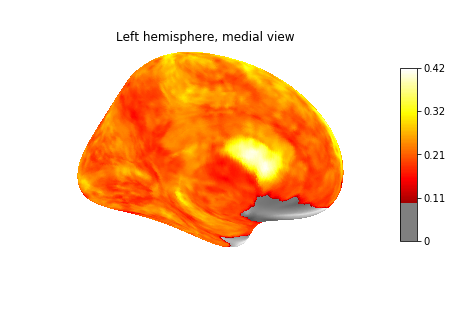

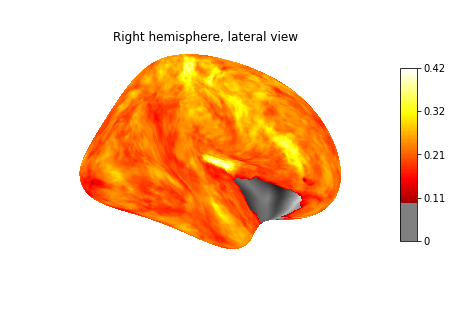

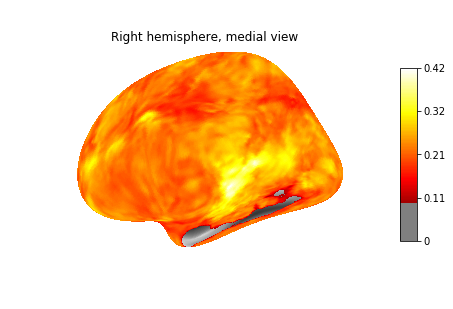

In [13]:
# visualization with nilearn again

# create a texture from the volumetric data
texture = surface.vol_to_surf(corrImgHyper,
                              fsaverage.pial_left,
                              interpolation='linear'
                              )
# 4 plots: left lateral and medial, right lateral and medial
plotting.plot_surf_stat_map(fsaverage.infl_left,
                            texture,
                            hemi='left',
                            threshold=0.10,
                            bg_map=fsaverage.sulc_left,
                            view='lateral',
                            symmetric_cbar=False,
                            title='Left hemisphere, lateral view'
                            )
plotting.plot_surf_stat_map(fsaverage.infl_left,
                            texture,
                            hemi='left',
                            threshold=0.10,
                            bg_map=fsaverage.sulc_left,
                            view='medial',
                            symmetric_cbar=False,
                            title='Left hemisphere, medial view'
                            )
plotting.plot_surf_stat_map(fsaverage.infl_right,
                            texture,
                            hemi='right',
                            threshold=0.10,
                            bg_map=fsaverage.sulc_right,
                            view='lateral',
                            symmetric_cbar=False,
                            title='Right hemisphere, lateral view'
                            )
plotting.plot_surf_stat_map(fsaverage.infl_right,
                            texture,
                            hemi='right',
                            threshold=0.10,
                            bg_map=fsaverage.sulc_right,
                            view='medial',
                            symmetric_cbar=False,
                            title='Right hemisphere, medial view'
                            )

<br>
<font size ="4">
<b>Sanity check passed with flying colors :)</b> 
Pymvpa hyperalignment works as advertised. As a next step we will use hyperalignment properly, deriving mappings from a part of the data and testing its effects in terms of ISC on held-out data. Stay tuned!
</font>
<br><br>